In [18]:
# Load and compile Julia packages for the current session
# This might take a while, needs to be done only once
# Recommended to list and compile all packages at once

using Distributions
using StatsBase
using CSV
using DataFrames
using StatsPlots
using Plots
gr()
using Dates
using PlotThemes


In [19]:
using InstantiateFromURL
github_project("vnegi10/covid19-notebooks-julia")


 Activating environment at `~/Desktop/Julia_training/COVID_19_analysis/Project.toml`


Info Project name is NA, version is NA


In [20]:
function find_country(data_df,country::String)
    data_df_new = data_df[ismissing.(data_df[!,Symbol("Province/State")]), :] # keep only rows with missing entry for "Province/State", total numbers for countries can be read this way
    loc = findfirst(data_df_new[!,Symbol("Country/Region")] .== country) # find the index of the row containing country
    return data_df_new[loc,:] # select the matching row
end

find_country (generic function with 1 method)

In [21]:
file = download("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
       "covid_19_global_data.csv"); # source of the data

data_df = DataFrame!(CSV.File("covid_19_global_data.csv")); # read data from file into a DataFrame

file = download("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", "covid_19_global_data_recovered.csv" ); # source of the data

data_df_recovered = DataFrame!(CSV.File("covid_19_global_data_recovered.csv")); # read data from file into a DataFrame

file = download("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", "covid_19_global_data_deaths.csv" ); # source of the data

data_df_deaths = DataFrame!(CSV.File("covid_19_global_data_deaths.csv")); # read data from file into a DataFrame


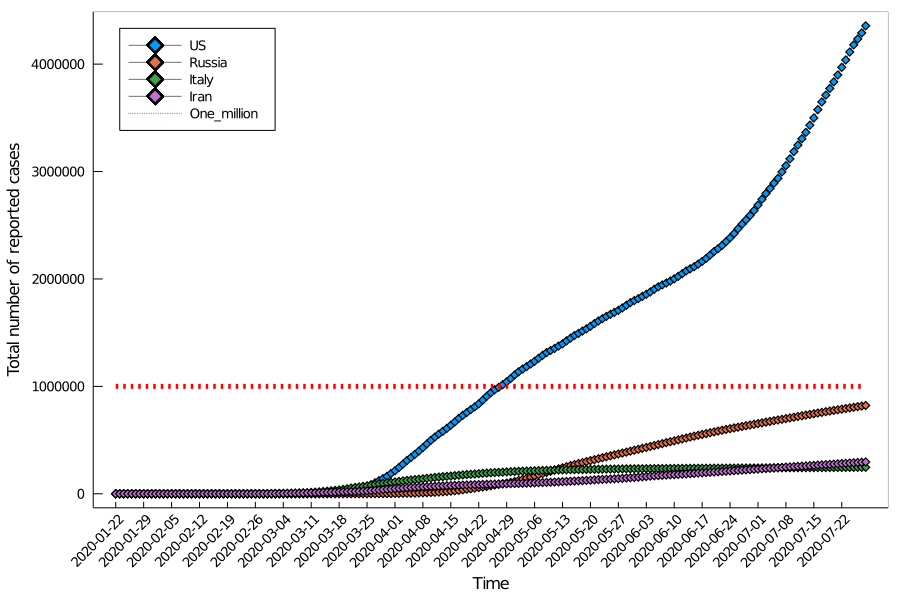

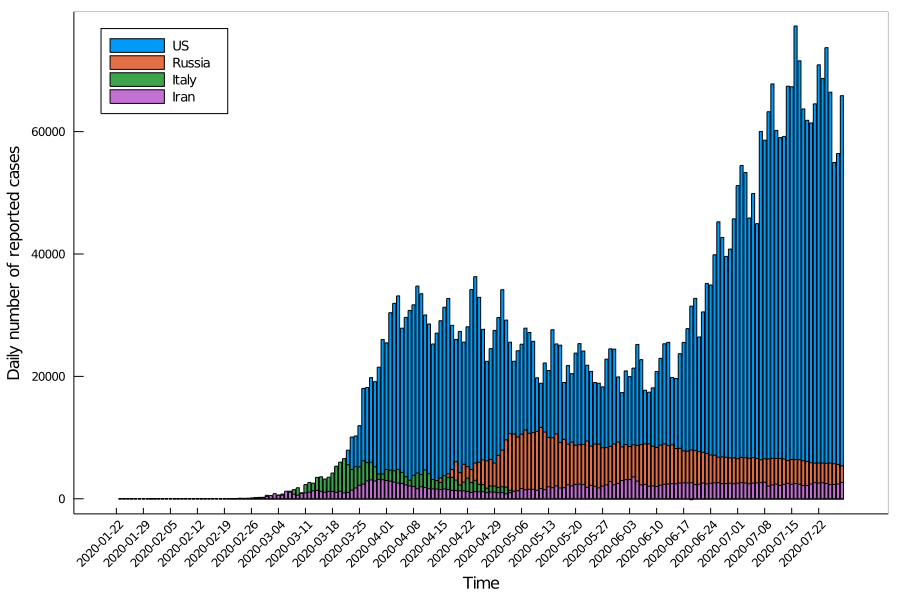

In [22]:
############################# Plot time series data for multiple countries ####################################

date_strings = names(data_df)[5:end]; # read dates from the column names
format = Dates.DateFormat("m/d/y")    # specify given format
x = parse.(Date, date_strings, format) .+ Year(2000) # Year(2000) converts year from 0020 to 2020

countries = ["US", "Russia", "Italy", "Iran"];
y = DataFrame() # empty dataframe

for country in countries
    
    data_dfr = find_country(data_df,country); # returns a dataframe row 
    data_dfr = DataFrame(data_dfr);           # convert dataframe row back to a dataframe
    rows, cols = size(data_dfr);
    data_dfl = stack(data_dfr, 5:cols);       # convert dataframe into long format
    y[!,Symbol("$country")] = data_dfl[!,:value]
end

if "India" in names(y)
    y[!,:India][141] = 286131 # correction for number of cases reported on 10-06-2020
end    

rows,cols = size(y)

gr(size=(900,600))
@df y plot(x, cols(1:cols), 
    label =  reshape(names(y),(1,length(names(y)))),
    xlabel = "Time",
    ylabel = "Total number of reported cases",
    xticks = x[1:7:end],
    xrotation = 45,
    marker = (:diamond,4),
    line = (:line, "gray"),
    legend = :topleft,
    grid = false,
    framestyle = :semi,
    legendfontsize = 9,
    tickfontsize = 9,
    formatter = :plain
    )

y.One_million = Array{Union{Missing,Int64},1}(missing,size(y,1));
y.One_million .= 10^6;

display(@df y plot!(x, y[!,cols+1],
       linestyle = :dot,
       linewidth = 5,
       color = :red,
       label = names(y)[cols+1]))

y = select!(y, Not([:One_million])); # remove column One_million

savefig("Time_series_1.png")


############################# Calculate number of daily reported cases ####################################


y_tmp = deepcopy(y);               # creates an independent copy, changes in y_tmp won't affect y
rows,cols = size(y_tmp)
dfrows = nrow(y_tmp);
name = names(y_tmp);

y_daily = similar(y_tmp,dfrows-1); # copy the structure to an empty dataframe with dfrows-1 rows

for j = 1:length(name)
    for i = 1:dfrows-1
        y_daily[!,name[j]][i] = y_tmp[!,name[j]][i+1] - y_tmp[!,name[j]][i] # calculate number of daily increase in reported cases by subtracting numbers of previous day
    end
end

x_daily = deepcopy(x);
popfirst!(x_daily);                # remove first entry, daily increase can only be reported from the next date

gr(size=(900,600))
display(@df y_daily bar(x_daily, cols(1:cols), 
    label = reshape(names(y),(1,length(names(y)))),
    xlabel = "Time",
    ylabel = "Daily number of reported cases",
    xticks = x[1:7:end],
    xrotation = 45,
    legend = :topleft,
    grid = false,
    framestyle = :semi,
    legendfontsize = 9,
    formatter = :plain))
    
    

savefig("Daily_cases_1.png")




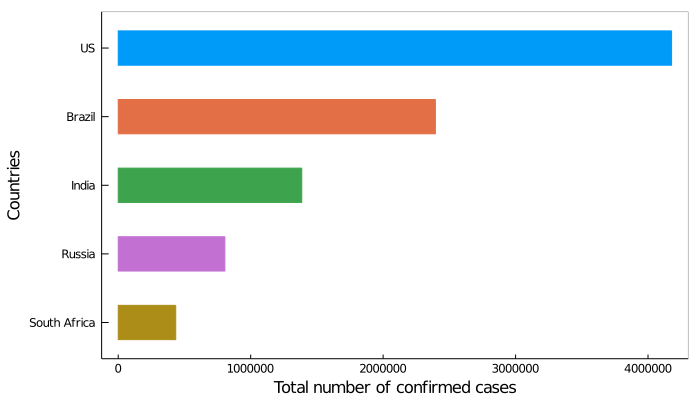

In [23]:
############################# Find top 5 countries with highest number of confirmed cases ####################################

sort!(data_df,Symbol("7/25/20"),rev=true)               # sort original DataFrame in descending order based on values in last column (latest date)
countries_sort = data_df[1:5,Symbol("Country/Region")]  # list of top 5 countries
latest_reported_cases = data_df[1:5,Symbol("7/25/20")]  # number of reported cases in top 5 countries

gr(size=(700,400))
display(bar(countries_sort, latest_reported_cases,
    orientation = :h,
    xlabel = "Total number of confirmed cases",
    ylabel = "Countries",
    legend = false,
    color = collect(1:length(countries_sort)),
    bar_width = 0.50,
    linecolor = :match,
    yflip=true,
    grid = false,
    framestyle=:semi,
    formatter = :plain
    ))

savefig("Top_five.png")

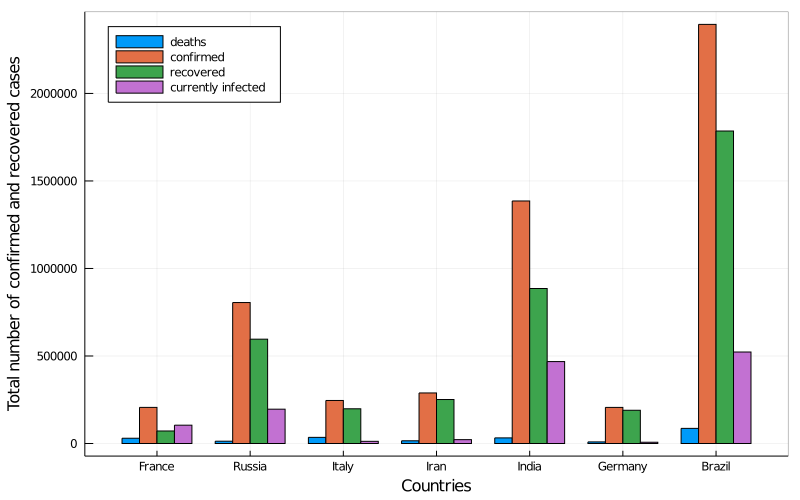

In [133]:
countries = ["France", "Russia", "Italy", "Iran", "India", "Germany", "Brazil"];
y_r = DataFrame()
y = DataFrame()
y_d = DataFrame()

# empty dataframe


################## For total confirmed cases #####################
for country in countries    
    data_dfr = find_country(data_df,country); # returns a dataframe row 
    data_dfr = DataFrame(data_dfr);           # convert dataframe row back to a dataframe
    rows, cols = size(data_dfr);
    data_dfl = stack(data_dfr, 5:cols);       # convert dataframe into long format
    y[!,Symbol("$country")] = data_dfl[!,:value]
end

################## For total recovered cases #####################
for country in countries    
    data_dfr_r = find_country(data_df_recovered,country); # returns a dataframe row 
    data_dfr_r = DataFrame(data_dfr_r);                   # convert dataframe row back to a dataframe
    rows, cols = size(data_dfr_r);
    data_dfl_r = stack(data_dfr_r, 5:cols);               # convert dataframe into long format
    y_r[!,Symbol("$country")] = data_dfl_r[!,:value]
end

################## For total deaths #####################
for country in countries    
    data_dfr_d = find_country(data_df_deaths,country); # returns a dataframe row 
    data_dfr_d = DataFrame(data_dfr_d);                   # convert dataframe row back to a dataframe
    rows, cols = size(data_dfr_d);
    data_dfl_d = stack(data_dfr_d, 5:cols);               # convert dataframe into long format
    y_d[!,Symbol("$country")] = data_dfl_d[!,:value]
end


confirmed_cases = vec(convert(Array, last(y,1)))          # convert dataframe row into an array
recovered_cases = vec(convert(Array, last(y_r,1)))
deaths          = vec(convert(Array, last(y_d,1)))

Y = Array{Float64,2}(undef, length(names(y_r)), 4)        # 2-D array with both confirmed and recovered cases
Y[:,2] = confirmed_cases
Y[:,3] = recovered_cases
Y[:,1] = deaths
Y[:,4] = Y[:,2] - (Y[:,3] + Y[:,1])                       # number of currently infected = confirmed - (recovered + deaths)


gr(size=(800,500))
groupedbar(names(y), Y, 
          bar_position = :dodge, 
          bar_width=0.75,
          #orientation = :h,
          ylabel = "Total number of confirmed and recovered cases",
          xlabel = "Countries",
          label=["deaths" "confirmed" "recovered" "currently infected"],
          #color = collect(1:length(names(y_r))),
          #yflip = true,
          framestyle = :semi,
          formatter = :plain,
          legend = :topleft,
          grid = true
          ) 


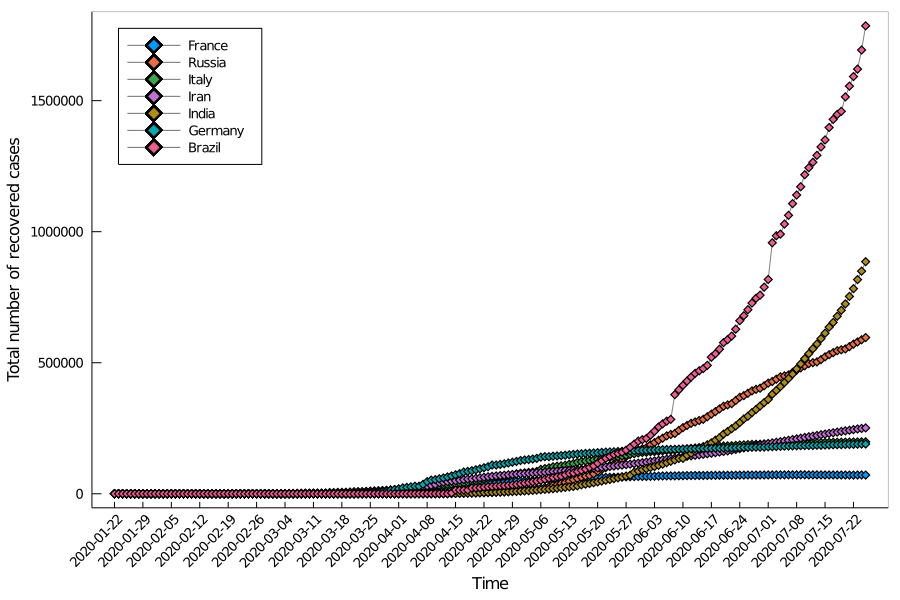

In [134]:
rows,cols = size(y_r)

gr(size=(900,600))
@df y_r plot(x, cols(1:cols), 
    label =  reshape(names(y),(1,length(names(y)))),
    xlabel = "Time",
    ylabel = "Total number of recovered cases",
    xticks = x[1:7:end],
    xrotation = 45,
    marker = (:diamond,4),
    line = (:line, "gray"),
    legend = :topleft,
    grid = false,
    framestyle = :semi,
    legendfontsize = 9,
    tickfontsize = 9,
    formatter = :plain,
    linecolor = :match
    )

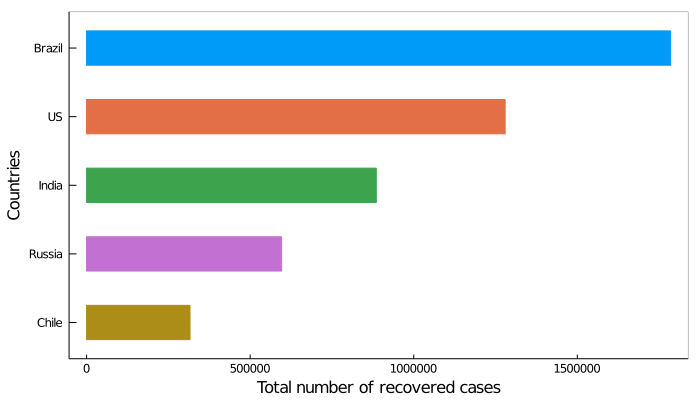

In [26]:
sort!(data_df_recovered,Symbol("7/25/20"),rev=true)                 # sort original DataFrame in descending order based on values in last column (latest date)
countries_sort_r = data_df_recovered[1:5,Symbol("Country/Region")]  # list of top 5 countries
latest_recovered_cases = data_df_recovered[1:5,Symbol("7/25/20")]   # number of recovered cases in top 5 countries

gr(size=(700,400))
display(bar(countries_sort_r, latest_recovered_cases,
    orientation = :h,
    xlabel = "Total number of recovered cases",
    ylabel = "Countries",
    legend = false,
    color = collect(1:length(countries_sort_r)),
    bar_width = 0.50,
    linecolor = :match,
    yflip=true,
    grid = false,
    framestyle=:semi,
    formatter = :plain
    ))
